In [1]:
#XGBOOST_NO_TUNING
#Private Score
#12.79118
#Public Score
#14.03881



import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from time import time
from datetime import timedelta

In [2]:
start = time()

# 1.导入数据

In [3]:
train = pd.read_csv('train.csv', nrows=None)
test = pd.read_csv('test.csv', nrows=None).set_index('id')

# 2.数据探索

## 2.1.检查空值与重复

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
date     913000 non-null object
store    913000 non-null int64
item     913000 non-null int64
sales    913000 non-null int64
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45000 entries, 0 to 44999
Data columns (total 3 columns):
date     45000 non-null object
store    45000 non-null int64
item     45000 non-null int64
dtypes: int64(2), object(1)
memory usage: 1.4+ MB


In [6]:
#去重操作
train.drop_duplicates(subset=['date', 'store', 'item'], keep='first', inplace=True)
test.drop_duplicates(subset=['date', 'store', 'item'], keep='first', inplace=True)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 913000 entries, 0 to 912999
Data columns (total 4 columns):
date     913000 non-null object
store    913000 non-null int64
item     913000 non-null int64
sales    913000 non-null int64
dtypes: int64(3), object(1)
memory usage: 34.8+ MB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45000 entries, 0 to 44999
Data columns (total 3 columns):
date     45000 non-null object
store    45000 non-null int64
item     45000 non-null int64
dtypes: int64(2), object(1)
memory usage: 1.4+ MB


## 2.2. 检查分布

In [9]:
#将date列转换为datetime数据类型
train.date=pd.to_datetime(train.date)
#test.date=pd.to_datetime(test.date)

(array([1.0000e+00, 4.0000e+00, 2.5000e+01, 9.1000e+01, 2.1500e+02,
        4.0400e+02, 7.9500e+02, 1.3360e+03, 2.0780e+03, 2.7810e+03,
        3.6020e+03, 4.5760e+03, 5.7360e+03, 6.6780e+03, 7.7020e+03,
        8.6910e+03, 9.8330e+03, 1.0552e+04, 1.1379e+04, 1.1982e+04,
        1.2423e+04, 1.3051e+04, 1.3413e+04, 1.3956e+04, 1.3812e+04,
        1.4027e+04, 1.4212e+04, 1.4231e+04, 1.4164e+04, 1.4178e+04,
        1.4283e+04, 1.4130e+04, 1.3818e+04, 1.3963e+04, 1.3774e+04,
        1.3591e+04, 1.3689e+04, 1.3685e+04, 1.3376e+04, 1.3121e+04,
        1.2809e+04, 1.2775e+04, 1.2669e+04, 1.2818e+04, 1.2536e+04,
        1.2368e+04, 1.1966e+04, 1.1897e+04, 1.1835e+04, 1.1809e+04,
        1.1580e+04, 1.1468e+04, 1.1251e+04, 1.0887e+04, 1.0864e+04,
        1.0648e+04, 1.0501e+04, 1.0352e+04, 1.0185e+04, 9.9920e+03,
        9.7620e+03, 9.5720e+03, 9.4030e+03, 9.2050e+03, 9.2020e+03,
        8.7350e+03, 8.5940e+03, 8.6260e+03, 8.2320e+03, 8.2080e+03,
        7.9600e+03, 7.6500e+03, 7.5760e+03, 7.24

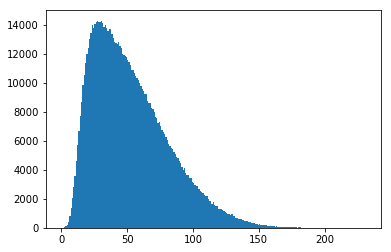

In [10]:
plt.hist(train.sales,bins=231)

231
0


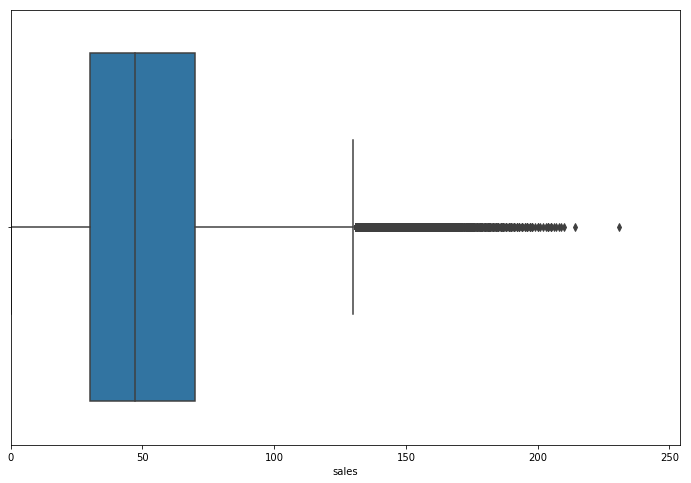

In [11]:
plt.figure(figsize=(12,8))
plt.xlim(train.sales.min(), train.sales.max()*1.1)
sns.boxplot(x=train.sales)

print(max(train.sales))
print(min(train.sales))

In [12]:
sales_Q1=train.sales.quantile(0.25)
sales_Q3=train.sales.quantile(0.75)
sales_IQR=sales_Q3-sales_Q1
print(sales_Q1-1.5*sales_IQR,sales_Q3+1.5*sales_IQR)
print(sales_Q1-3*sales_IQR,sales_Q3+3*sales_IQR)
# 按箱型图理论，在Q3+1.5IQR和Q1－1.5IQR区间以外在Q3+1.5IQR和Q1－1.5IQR以内的是温和的异常值（mild outliers），
# 在Q3+1.5IQR和Q1－1.5IQR以内的是极端的异常值(extreme outliers)
# -30.0 130.0
# -90.0 190.0

-30.0 130.0
-90.0 190.0


In [13]:
#温和异常值有11967条数据
len(train[train.sales>130])

11967

In [14]:
len(train[train.sales>190])

50

In [15]:
train.sales.value_counts()[-30:]
#极端异常值有50条数据
#但似乎出现这样的数据也正常

#但这只是根据经验的归纳,查看销量数据，这些所谓极端异常值也并不很离群，所以不做处理。

187    13
186     9
190     9
191     8
185     7
188     7
189     6
194     5
196     4
1       4
198     3
197     3
204     3
205     3
193     3
192     3
200     2
195     2
231     1
214     1
199     1
201     1
202     1
203     1
206     1
207     1
208     1
209     1
210     1
0       1
Name: sales, dtype: int64

In [16]:
#将唯一销量0改为1，以便损失函数或度量函数可采用mape
train.loc[train[train.sales==0].index,'sales']=1

销售数据呈偏态分布，按箱型图理论，有50/913000销量数据在极端异常值，有（11967-50）/913000数据处于温和异常值。但这是一种经验理论，而且处于所谓极端异常值数据相互间并没有相隔很远，因此我认为这些销量是正常的，故不作处理。

## 2.3. 时间序列查看趋势

In [17]:
train_copy = train.copy()
date_mean = train_copy.groupby(['date'])['sales'].mean().reset_index()
del train_copy

E:\toolkits.win\anaconda\envs\ml\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


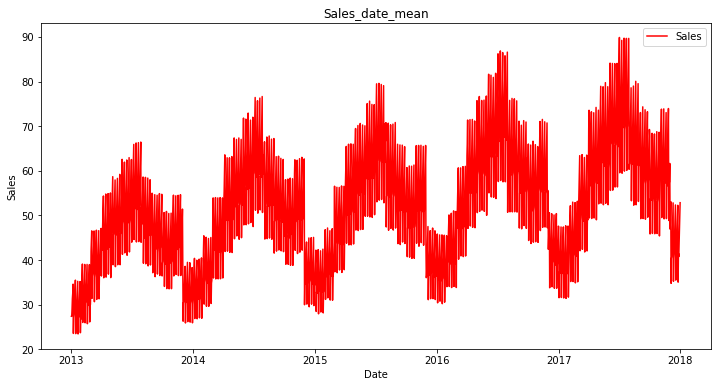

In [18]:
plt.rcParams['figure.figsize'] = (12, 6)
fig, ax = plt.subplots()

ax.plot(date_mean.date,date_mean.sales,'r',label='Sales')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title("Sales_date_mean")
ax.legend()
plt.show()

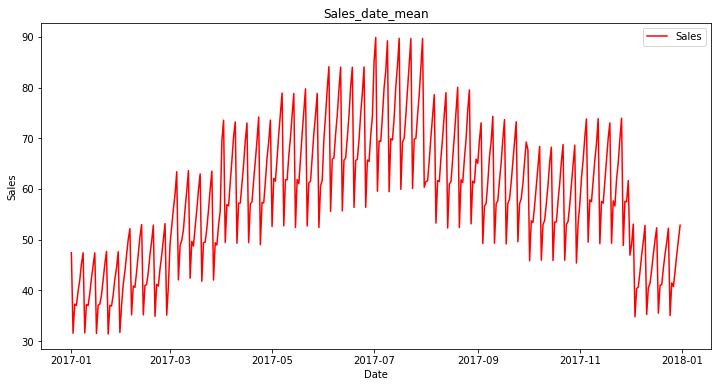

In [19]:
plt.rcParams['figure.figsize'] = (12, 6)
fig, ax = plt.subplots()

ax.plot(date_mean.date[-365:],date_mean.sales[-365:],'r',label='Sales')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title("Sales_date_mean")
ax.legend()
plt.show()

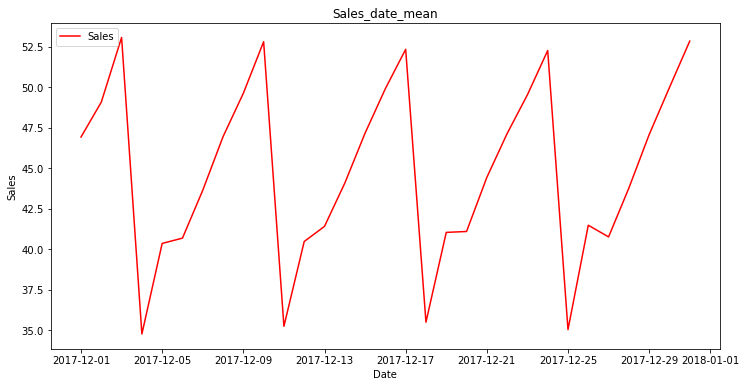

In [20]:
plt.rcParams['figure.figsize'] = (12, 6)
fig, ax = plt.subplots()

ax.plot(date_mean.date[-31:],date_mean.sales[-31:],'r',label='Sales')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title("Sales_date_mean")
ax.legend()
plt.show()

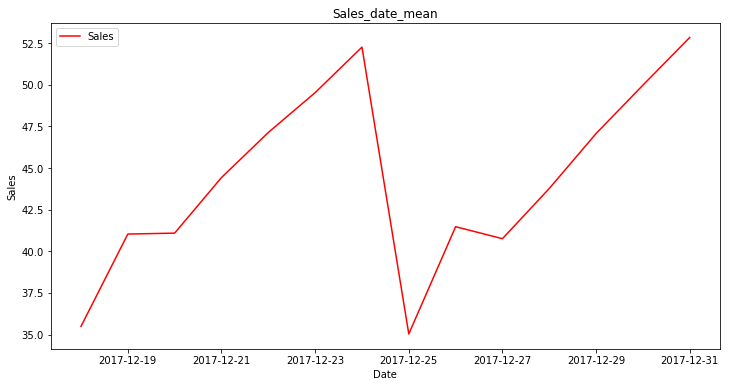

In [21]:
plt.rcParams['figure.figsize'] = (12, 6)
fig, ax = plt.subplots()

ax.plot(date_mean.date[-14:],date_mean.sales[-14:],'r',label='Sales')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title("Sales_date_mean")
ax.legend()
plt.show()

In [22]:
date_mean.insert(1,'year',date_mean.date.dt.year)
date_mean.insert(2,'quarter',date_mean.date.dt.quarter)
date_mean.head()

date  year  quarter   sales
0 2013-01-01  2013        1  27.392
1 2013-01-02  2013        1  27.356
2 2013-01-03  2013        1  28.976
3 2013-01-04  2013        1  31.354
4 2013-01-05  2013        1  32.474

In [23]:
year_mean = date_mean.groupby(['year'])['sales'].mean().reset_index()
year_mean

year      sales
0  2013  43.513660
1  2014  50.057441
2  2015  52.256915
3  2016  56.596503
4  2017  58.815014

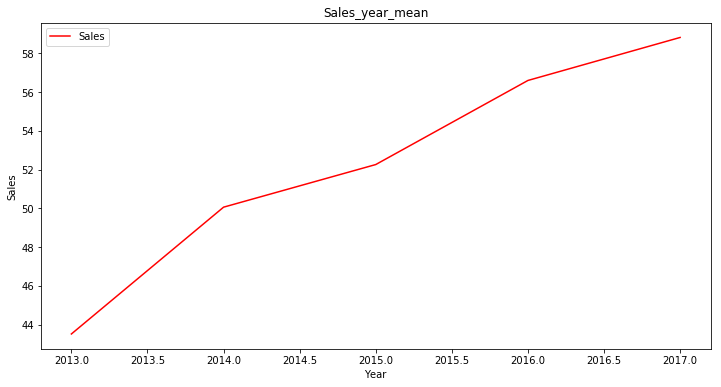

In [24]:
plt.rcParams['figure.figsize'] = (12, 6)
fig, ax = plt.subplots()

ax.plot(year_mean.year,year_mean.sales,'r',label='Sales')
ax.set_xlabel('Year')
ax.set_ylabel('Sales')
ax.set_title("Sales_year_mean")
ax.legend()
plt.show()

In [25]:
quarter1 = date_mean[date_mean.quarter==1]
quarter1.tail()

date  year  quarter   sales
1546 2017-03-27  2017        1  42.026
1547 2017-03-28  2017        1  49.386
1548 2017-03-29  2017        1  48.948
1549 2017-03-30  2017        1  52.786
1550 2017-03-31  2017        1  55.666

In [26]:
year_quarter1_mean = quarter1.groupby(['year'])['sales'].mean().reset_index()
year_quarter1_mean

year      sales
0  2013  34.037844
1  2014  39.097911
2  2015  40.772911
3  2016  44.137956
4  2017  45.807600

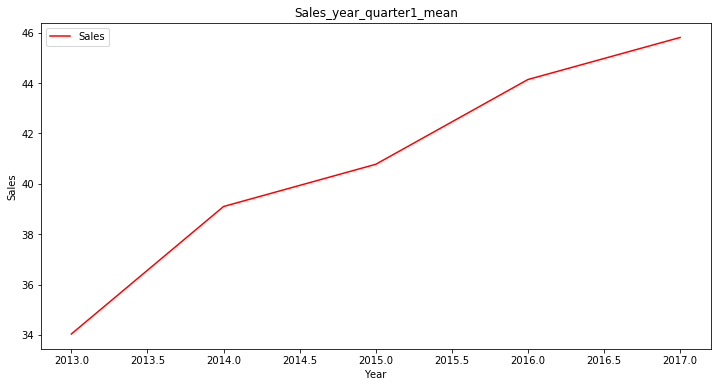

In [27]:
plt.rcParams['figure.figsize'] = (12, 6)
fig, ax = plt.subplots()

ax.plot(year_quarter1_mean.year,year_quarter1_mean.sales,'r',label='Sales')
ax.set_xlabel('Year')
ax.set_ylabel('Sales')
ax.set_title("Sales_year_quarter1_mean")
ax.legend()
plt.show()

In [28]:
del date_mean,year_mean,quarter1,year_quarter1_mean

可以看出销量呈现明显年周期和星期周期性。

# 3.构造更多特征
显然，只有日期、店铺分类、商品分类并不足以解释销量的信息。按照信息熵理论，这三个变量的信息熵远小于销量的信息熵。时序数据最大的信息来源于过往数据，应利用起来。但是，利用往期数据谨防泄露（leakage）。
我将增加三种类型的特征：
1. 时间特征

即将date转化成year、month、day等。
2. 平移特征

平移特征也成为lag特征，通过将对象value进行平移操作，获取的特征。通过shift函数实现(含有多列，shift多有不变，可直接date列+periods)。若periods参数小于90，那么2018年3月31时候的平移特征将含有2018年某天销量，这天的销量是不知道的。所以为保证能进行20018年头三个月的预测，其periods参数必须大于等于90。假设浪费一年数据用来构造特征，那么periods也应小于等于365.
3. 窗口特征

即窗口内取平均值、最大值和最小值等。通过rolling().mean()等实现。rolling函数默认将mean等结果显示在窗口末尾，那么必须进行shiift(periods>=90，含有多列，shift多有不变，可直接date列+periods)，且periods+window-1<=365。

4. 分类平均
与第三类特征不同，不再沿着日期平均，这次沿着分类特征平均。

5. 不同商店、货物差值

6. 与窗口平均比较的极大值、极小值标记

In [29]:
df_all = train
df_all = df_all.sort_values(by=['store','item','date'])
del train  #,test

In [30]:
sales = df_all.pop('sales')
df_all.insert(0,'sales',sales)

In [31]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 913000 entries, 0 to 912999
Data columns (total 4 columns):
sales    913000 non-null int64
date     913000 non-null datetime64[ns]
store    913000 non-null int64
item     913000 non-null int64
dtypes: datetime64[ns](1), int64(3)
memory usage: 34.8 MB


In [32]:
df_all.store = df_all.store.astype(np.int8)
df_all.item = df_all.item.astype(np.int8)
df_all.sales = df_all.sales.astype(np.int16)

In [33]:
from sklearn import metrics as mr
print(mr.mutual_info_score(df_all.sales,df_all.sales))
for i in df_all.columns[1:]:
    print(i, mr.mutual_info_score(df_all.sales,df_all.loc[:,i]))

4.668257396303383
date 0.25756156006867154
store 0.08080738800839304
item 0.469412480597298


In [34]:
#add_window
def add_window(df,window=2):
    df_copy = df.copy()
    df_copy = df_copy[['sales','date','store','item']]
    df_copy = df_copy.set_index('date')
    df_copy_roll = df_copy.groupby(['store','item'])['sales'].rolling(window=window).mean().reset_index()
      
    df_copy_roll['sales'] = df_copy_roll['sales'].astype(np.float32)
    
    new_name='sales_window{0}_mean'.format(window)
    df_copy_roll.rename(columns={'sales':new_name}, inplace=True)
    df = df.merge(df_copy_roll,on=['date','store','item'],how='left')
    del df_copy,df_copy_roll,new_name
    return df

In [35]:
#add_store_group
def add_store_group(df):
    df_copy = df.copy()
    df_copy = df_copy[['sales','date','store','item']]
    df_copy = df_copy.groupby(['date','store'])['sales'].mean().reset_index()
      
    df_copy['sales'] = df_copy['sales'].astype(np.float32)
    
    new_name='sales_store_mean'
    df_copy.rename(columns={'sales':new_name}, inplace=True)
    df = df.merge(df_copy,on=['date','store'],how='left')
    del df_copy,new_name
    return df

In [36]:
#add_item_group
def add_item_group(df):
    df_copy = df.copy()
    df_copy = df_copy[['sales','date','store','item']]
    df_copy = df_copy.groupby(['date','item'])['sales'].mean().reset_index()
      
    df_copy['sales'] = df_copy['sales'].astype(np.float32)
    
    new_name='sales_item_mean'
    df_copy.rename(columns={'sales':new_name}, inplace=True)
    df = df.merge(df_copy,on=['date','item'],how='left')
    del df_copy,new_name
    return df    

In [37]:
df_all = add_store_group(df_all)
df_all = add_item_group(df_all)

df_all = add_window(df_all,2)
df_all = add_window(df_all,3)
df_all = add_window(df_all,4)
df_all = add_window(df_all,5)
df_all = add_window(df_all,6)
df_all = add_window(df_all,7)

In [38]:
def add_lag(df,periods,lag_col='sales'):
    #df:columns:date,store,item,sales and so on
    #periods:periods to shift,
    #for this very project,90<=periods<=365
    #maybe periods=i*week or i*month
    df_shift = df.copy()
    df_shift = df_shift[['date','store','item',lag_col]]
    #from datetime import timedelta
    df_shift.date = df_shift.date+timedelta(periods)
    new_name=lag_col+'_lag{0}'.format(periods)
    df_shift.rename(columns={lag_col:new_name}, inplace=True)
    df = df.merge(df_shift,on=['date','store','item'],how='left')
    del df_shift,new_name
    return df

In [39]:
column_window = df_all.columns[-6:]
window_lag_list = [358]+list(range(357,200,-7))+[91,90]
other_lag_list = list(range(365,357,-1))+list(range(357,200,-7))+[91,90]

In [40]:
#   sales_window2_mean\3\4\5\6\7
ts = time()
for j in column_window:
    for i in window_lag_list:  #358,300,-7
        df_all = add_lag(df_all,i,lag_col=j)
    df_all.drop(j,axis=1,inplace=True)
time() - ts

157.29692840576172

In [41]:
ts = time()
for i in other_lag_list:  #365,250,-1
    df_all = add_lag(df_all,i,lag_col='sales')
time() - ts

42.25670599937439

In [42]:
ts = time()
for i in other_lag_list:  #364,200,-7
    df_all = add_lag(df_all,i,lag_col='sales_store_mean')
df_all.drop('sales_store_mean',axis=1,inplace=True)
time() - ts

84.6533715724945

In [43]:
ts = time()
for i in other_lag_list:   #364,200,-7
    df_all = add_lag(df_all,i,lag_col='sales_item_mean')
df_all.drop('sales_item_mean',axis=1,inplace=True)
time() - ts

98.7822482585907

In [44]:
def add_datetime_properties(df,position=1,add_year=True,add_month=True,add_dayofweek=True,
                            add_day=True,add_weekofyear=True):
                            

    
    if add_year==True:
        df.insert(position,'year',df.date.dt.year)
        df.year = df.year.astype(np.int16)

    
    if add_month==True:
        df.insert(position,'month',df.date.dt.month)
        df.month = df.month.astype(np.int8)     
        
        
    if add_day==True:
        df.insert(position,'day',df.date.dt.day)
        df.day = df.day.astype(np.int8)             
        
        
    if add_dayofweek==True:
        df.insert(position,'dayofweek',df.date.dt.dayofweek)
        df.dayofweek = df.dayofweek.astype(np.int8)
        
    if add_weekofyear==True:
        df.insert(position,'weekofyear',df.date.dt.weekofyear)
        df.weekofyear = df.weekofyear.astype(np.int8)
       
    return df

In [45]:
#距数据起始时间的月数天数
def total_from_start(df,position=1):        
    #df.insert(position,'month_from_start',df.date.dt.month+(df.date.dt.year-2013)*12)
    #df.month_from_start = df.month_from_start.astype(np.int8) 
    
    from datetime import datetime
    df.insert(position,'day_from_start',(df.date-datetime(2013,1,1)).dt.days)
    df.day_from_start = df.day_from_start.astype(np.int16)
    
    return df

In [46]:
#datetime properties能添加的有17项目，但是2013年初到2017年末共5年数据只有1年是闰年，
#需要用到目标变量构造新的特征，为防止泄露（leakage）
#需要从train中专门分出一个数据集来构造特征（这部分知识在feature-engineering-for-machine-learning机器学习的特征工程alice-zhang）
#所以is_leap_year没必要添加。
df_all=add_datetime_properties(df_all)

df_all=total_from_start(df_all)

In [47]:
def add_history_mean(df,computing,col1,col2,col3,mean_col):
    #col1:month\day
    #col2:weekofyear\dayofweek 
    
    # one column
    for i in col1+col2+col3:
        keys=[i]
        right=computing.groupby(keys)[mean_col].mean()
        right = right.astype(np.float32) #float64 float32 or float16
        right = right.reset_index()
        new_name='sales_history_{0}_mean'.format(keys[0]) 
        right.rename(columns={'sales':new_name}, inplace = True)
        df=pd.merge(df,right, how='left', on=keys,suffixes=('_x', '_y'), copy=False, indicator=False)
        
    #two columns        
    for i in col1+col2:
        for j in col3:
            keys=[i,j]
            right=computing.groupby(keys)[mean_col].mean()
            right = right.astype(np.float32) #float64 float32 or float16
            right = right.reset_index()
            new_name='sales_history_{0}_{1}_mean'.format(keys[0],keys[1]) 
            right.rename(columns={'sales':new_name}, inplace = True)
            df=pd.merge(df,right, how='left', on=keys,suffixes=('_x', '_y'), copy=False, indicator=False)
            
    keys = col1
    right=computing.groupby(keys)[mean_col].mean()
    right = right.astype(np.float32) #float64 float32 or float16
    right = right.reset_index()
    new_name='sales_history_{0}_{1}_mean'.format(keys[0],keys[1]) 
    right.rename(columns={'sales':new_name}, inplace = True)
    df=pd.merge(df,right, how='left', on=keys,suffixes=('_x', '_y'), copy=False, indicator=False)
    
    keys = col2
    right=computing.groupby(keys)[mean_col].mean()
    right = right.astype(np.float32) #float64 float32 or float16
    right = right.reset_index()
    new_name='sales_history_{0}_{1}_mean'.format(keys[0],keys[1]) 
    right.rename(columns={'sales':new_name}, inplace = True)
    df=pd.merge(df,right, how='left', on=keys,suffixes=('_x', '_y'), copy=False, indicator=False)
    
    keys = col3
    right=computing.groupby(keys)[mean_col].mean()
    right = right.astype(np.float32) #float64 float32 or float16
    right = right.reset_index()
    new_name='sales_history_{0}_{1}_mean'.format(keys[0],keys[1]) 
    right.rename(columns={'sales':new_name}, inplace = True)
    df=pd.merge(df,right, how='left', on=keys,suffixes=('_x', '_y'), copy=False, indicator=False)
    
    # three columns
    for i in col1:
        keys=[i]+col3
        right=computing.groupby(keys)[mean_col].mean()
        right = right.astype(np.float32) #float64 float32 or float16
        right = right.reset_index()
        new_name='sales_history_{0}_{1}_{2}_mean'.format(keys[0],keys[1],keys[2]) 
        right.rename(columns={'sales':new_name}, inplace = True)
        df=pd.merge(df,right, how='left', on=keys,suffixes=('_x', '_y'), copy=False, indicator=False)
        
    for i in col2:
        keys=[i]+col3
        right=computing.groupby(keys)[mean_col].mean()
        right = right.astype(np.float32) #float64 float32 or float16
        right = right.reset_index()
        new_name='sales_history_{0}_{1}_{2}_mean'.format(keys[0],keys[1],keys[2]) 
        right.rename(columns={'sales':new_name}, inplace = True)
        df=pd.merge(df,right, how='left', on=keys,suffixes=('_x', '_y'), copy=False, indicator=False)
        
    for i in col3:
        keys=[i]+col1
        right=computing.groupby(keys)[mean_col].mean()
        right = right.astype(np.float32) #float64 float32 or float16
        right = right.reset_index()
        new_name='sales_history_{0}_{1}_{2}_mean'.format(keys[0],keys[1],keys[2]) 
        right.rename(columns={'sales':new_name}, inplace = True)
        df=pd.merge(df,right, how='left', on=keys,suffixes=('_x', '_y'), copy=False, indicator=False)
        
    for i in col3:
        keys=[i]+col2
        right=computing.groupby(keys)[mean_col].mean()
        right = right.astype(np.float32) #float64 float32 or float16
        right = right.reset_index()
        new_name='sales_history_{0}_{1}_{2}_mean'.format(keys[0],keys[1],keys[2]) 
        right.rename(columns={'sales':new_name}, inplace = True)
        df=pd.merge(df,right, how='left', on=keys,suffixes=('_x', '_y'), copy=False, indicator=False)
        

    #four columns
    keys = col1+col3
    right=computing.groupby(keys)[mean_col].mean()
    right = right.astype(np.float32) #float64 float32 or float16
    right = right.reset_index()
    new_name='sales_history_{0}_{1}_{2}_{3}_mean'.format(keys[0],keys[1],keys[2],keys[3]) 
    right.rename(columns={'sales':new_name}, inplace = True)
    df=pd.merge(df,right, how='left', on=keys,suffixes=('_x', '_y'), copy=False, indicator=False)
    
    keys = col2+col3
    right=computing.groupby(keys)[mean_col].mean()
    right = right.astype(np.float32) #float64 float32 or float16
    right = right.reset_index()
    new_name='sales_history_{0}_{1}_{2}_{3}_mean'.format(keys[0],keys[1],keys[2],keys[3]) 
    right.rename(columns={'sales':new_name}, inplace = True)
    df=pd.merge(df,right, how='left', on=keys,suffixes=('_x', '_y'), copy=False, indicator=False)
    
    return df

In [48]:
computing_2013 = df_all[(df_all.year==2013)]

df_all = add_history_mean(df_all,computing_2013,['weekofyear', 'dayofweek'], ['day', 'month'], ['store', 'item'],'sales')

In [49]:
def get_mpe(df,window):
    #df:用来计算窗口平均的历史数据，必须含有date、store、item、sales列
    #window：窗口平均的期数
    #return：mpe，含有date、store、item、mape_window3(比如窗口期数为3)
    #其中mpe列为窗口平均与销量的差值除以销量。
    for i in range(1,11):
        for j in range(1,51):
            copy = df[(df.store==i)&(df.item==j)]
            copy = copy[['date','sales']]
            copy = copy.set_index('date')
            s_i_mpe = (copy.rolling(window=window).mean()-copy)/copy
            s_i_mpe = s_i_mpe.fillna(0)
            s_i_mpe.insert(1,'store',i)
            s_i_mpe.insert(2,'item',j)
            if 'mpe' not in locals() and 'mpe' not in globals():  #判断是否存在mpe
                mpe = s_i_mpe
            else:
                mpe = pd.concat([mpe,s_i_mpe])
    mpe = mpe.reset_index()
    mpe = mpe.sort_values(by=['sales'])
    sales = mpe.pop('sales')
    mpe.insert(mpe.shape[1],'sales',sales)
    new_name = 'mpe_window{0}'.format(window)
    mpe.rename(columns={'sales':new_name}, inplace=True)
    del copy,s_i_mpe,new_name
    return mpe

In [50]:
ts = time()
mpe_window2 = get_mpe(computing_2013,2)
mpe_window3 = get_mpe(computing_2013,3)
mpe_window4 = get_mpe(computing_2013,4)
mpe_window5 = get_mpe(computing_2013,5)
mpe_window6 = get_mpe(computing_2013,6)
mpe_window7 = get_mpe(computing_2013,7)

del computing_2013
print(time()-ts)

20.278087377548218


In [51]:
def add_extrme(df,mpe,large_rate=0.1,small_rate=0.1,month_day_concat=True,weekofyear_dayofweek_concat=True):
    #df:需要添加列的时间数据，
    #mpe：即get_mpe的返回函数，需要注意的是，mpe的计算应采用不参与训练的数据计算。
    #参考其它时期数据有泄露的嫌疑，但似乎也不尽然？？？
    
    #large_percent：极大值占的比例
    #small_percent：极小值占的比例
    #month_day_concat：是否按月、日合并
    #weekofyear_dayofweek_concat：是否按一年的周数、星期合并
    #return：df：添加了mpe极大极小值对应的日期对应的月、日的标记，极大值标为1，极小值标为-1，其他值标为0，
    #若mpe参考了不止一年数据，则对应标记取平均再四舍五入到整数。
    extrme_large = mpe[-int(len(mpe)*large_rate):]
    extrme_large.insert(1,'extrme',0.999)
    extrme_small = mpe[:int(len(mpe)*small_rate)]
    extrme_small.insert(1,'extrme',-0.999)
    extrme = pd.concat([extrme_large,extrme_small],axis=0)
    extrme = extrme[['date','store','item','extrme']]
    if month_day_concat is True:
        extrme_1 = extrme.copy()
        extrme_1.insert(1,'month',extrme_1.date.dt.month)
        extrme_1.insert(1,'day',extrme_1.date.dt.day)
        extrme_1 = extrme_1.drop(['date'],axis=1)
        extrme_1_grouped = extrme_1.groupby(['month','day','store','item'])['extrme'].mean().reset_index()
        extrme_1_grouped.extrme = extrme_1_grouped.extrme.round()
        
        df = df.merge(extrme_1_grouped,on=['month','day','store','item'],how='left')
        df.extrme = df.extrme.fillna(0)
        df.extrme = df.extrme.astype(np.int8)
        new_name='sales_extrme_'+mpe.columns[-1]+\
        '_month_day_concat_large_{0}_thousandths_small_{1}_thousandths'.\
        format(int(1000*large_rate),int(1000*small_rate))
        df.rename(columns={'extrme':new_name}, inplace=True)
    
    if weekofyear_dayofweek_concat is True:
        extrme_2 = extrme.copy()
        extrme_2.insert(1,'weekofyear',extrme_2.date.dt.weekofyear)
        extrme_2.insert(1,'dayofweek',extrme_2.date.dt.dayofweek)
        extrme_2 = extrme_2.drop(['date'],axis=1)
        extrme_2_grouped = extrme_2.groupby(['weekofyear','dayofweek','store','item'])['extrme'].mean().reset_index()
        extrme_2_grouped.extrme = extrme_2_grouped.extrme.round()
        
        df = df.merge(extrme_2_grouped,on=['weekofyear','dayofweek','store','item'],how='left')
        df.extrme = df.extrme.fillna(0)
        df.extrme = df.extrme.astype(np.int8)
        new_name='sales_extrme_'+mpe.columns[-1]+\
        '_weekofyear_dayofweek_concat_large_{0}_thousandths_small_{1}_thousandths'.\
        format(int(1000*large_rate),int(1000*small_rate))
        df.rename(columns={'extrme':new_name}, inplace=True)
    

    del extrme_large,extrme_small,extrme,extrme_1,extrme_2,new_name
    return df

In [52]:
rate_list = [2*10**(-2)*i for i in range(1,26)]

In [53]:
ts = time()
for i in rate_list:
    df_all = add_extrme(df_all,mpe_window2,i,i)
print(time()-ts)

174.90803980827332


In [54]:
ts = time()
for i in rate_list: #1，51
    df_all = add_extrme(df_all,mpe_window3,i,i)
print(time()-ts)

184.1297345161438


In [55]:
ts = time()
for i in rate_list:
    df_all = add_extrme(df_all,mpe_window4,i,i)
print(time()-ts)

195.97084546089172


In [56]:
ts = time()
for i in rate_list:
    df_all = add_extrme(df_all,mpe_window5,i,i)
print(time()-ts)

208.39550590515137


In [57]:
ts = time()
for i in rate_list:
    df_all = add_extrme(df_all,mpe_window6,i,i)
print(time()-ts)

222.22090816497803


In [58]:
ts = time()
for i in rate_list:
    df_all = add_extrme(df_all,mpe_window7,i,i)
print(time()-ts)

232.0511507987976


In [59]:
def add_mpe(df,mpe,month_day_concat=True,weekofyear_dayofweek_concat=True):
    #df:需要添加列的时间数据，
    #mpe：即get_mpe的返回函数，需要注意的是，mpe的计算应采用不参与训练的2013年的数据计算。
    #参考其它时期数据有泄露的嫌疑，但似乎也不尽然？？？
    
    #large_percent：极大值占的比例
    #small_percent：极小值占的比例
    #month_day_concat：是否按月、日合并
    #weekofyear_dayofweek_concat：是否按一年的周数、星期合并
    #return：df：添加了不参与训练的历史数据窗口平均与实际值的mpe
    #若mpe参考了不止一年数据，则对应标记取平均。
    
    if month_day_concat is True:
        mpe_1 = mpe.copy()
        mpe_1.insert(1,'month',mpe_1.date.dt.month)
        mpe_1.insert(1,'day',mpe_1.date.dt.day)
        mpe_1 = mpe_1.drop(['date'],axis=1)
        mpe_1_grouped = mpe_1.groupby(['month','day','store','item'])[mpe.columns[-1]].mean().reset_index()
        mpe_1_grouped[mpe.columns[-1]] = mpe_1_grouped[mpe.columns[-1]].round()
        mpe_1_grouped[mpe.columns[-1]] = mpe_1_grouped[mpe.columns[-1]].astype(np.float32)
        
        df = df.merge(mpe_1_grouped,on=['month','day','store','item'],how='left')
        df[mpe.columns[-1]] = df[mpe.columns[-1]].fillna(0)
        df[mpe.columns[-1]] = df[mpe.columns[-1]].astype(np.float32)
        new_name='sales_'+mpe.columns[-1]+'_month_day_concat'
        df.rename(columns={mpe.columns[-1]:new_name}, inplace=True)
    
    if weekofyear_dayofweek_concat is True:
        mpe_2 = mpe.copy()
        mpe_2.insert(1,'weekofyear',mpe_2.date.dt.month)
        mpe_2.insert(1,'dayofweek',mpe_2.date.dt.day)
        mpe_2 = mpe_2.drop(['date'],axis=1)
        mpe_2_grouped = mpe_2.groupby(['weekofyear','dayofweek','store','item'])[mpe.columns[-1]].mean().reset_index()
        mpe_2_grouped[mpe.columns[-1]] = mpe_2_grouped[mpe.columns[-1]].round()
        mpe_2_grouped[mpe.columns[-1]] = mpe_2_grouped[mpe.columns[-1]].astype(np.float32)
        
        df = df.merge(mpe_2_grouped,on=['weekofyear','dayofweek','store','item'],how='left')
        df[mpe.columns[-1]] = df[mpe.columns[-1]].fillna(0)
        df[mpe.columns[-1]] = df[mpe.columns[-1]].astype(np.float32)
        new_name='sales_'+mpe.columns[-1]+'_weekofyear_dayofweek_concat'
        df.rename(columns={mpe.columns[-1]:new_name}, inplace=True)
    

    del mpe_1,mpe_1_grouped,mpe_2,mpe_2_grouped,new_name
    return df

In [60]:
df_all = add_mpe(df_all,mpe_window2)
df_all = add_mpe(df_all,mpe_window3)
df_all = add_mpe(df_all,mpe_window4)
df_all = add_mpe(df_all,mpe_window5)
df_all = add_mpe(df_all,mpe_window6)
df_all = add_mpe(df_all,mpe_window7)

In [61]:
del mpe_window2,mpe_window3,mpe_window4,mpe_window5,mpe_window6,mpe_window7

In [62]:
from sklearn import metrics as mr
print(mr.mutual_info_score(df_all.sales,df_all.sales))
for i in df_all.columns[1:]:
    #print(i,df_all.loc[:,i].shape)
    print(i, mr.mutual_info_score(df_all.sales,df_all.loc[:,i]))

4.668257396303383
day_from_start 0.25756156006867154
weekofyear 0.07134755789114708
dayofweek 0.030077094301948566
day 0.0034466399745189747
month 0.06965465974410086
year 0.020220463612645005
date 0.25756156006867154
store 0.08080738800839304
item 0.469412480597298
sales_window2_mean_lag358 1.5818288716989122
sales_window2_mean_lag357 1.6831127159719836
sales_window2_mean_lag350 1.6350739167481605
sales_window2_mean_lag343 1.5912761813132787
sales_window2_mean_lag336 1.5494028843646415
sales_window2_mean_lag329 1.4991327779432337
sales_window2_mean_lag322 1.4491514437009096
sales_window2_mean_lag315 1.4025640385711766
sales_window2_mean_lag308 1.3594745180085976
sales_window2_mean_lag301 1.316946844586016
sales_window2_mean_lag294 1.2780753003551122
sales_window2_mean_lag287 1.2424093976663562
sales_window2_mean_lag280 1.2099545324991507
sales_window2_mean_lag273 1.180408408676773
sales_window2_mean_lag266 1.1498798248381195
sales_window2_mean_lag259 1.1212810842636065
sales_window2_m

In [63]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 913000 entries, 0 to 912999
Columns: 604 entries, sales to sales_mpe_window7_weekofyear_dayofweek_concat
dtypes: datetime64[ns](1), float32(261), float64(33), int16(3), int8(306)
memory usage: 1.4 GB


In [64]:
df_all = df_all.sort_values(by=['store','item','date'])

df_all.to_pickle('./catboost/df_all_cat.pkl')
del df_all

# 4.模型训练
为什么采用catboost？
集成方法中boost方法也许是最有效的，那么有3个选择catboost、lightgbm和xgboost。
此3个包运算速度依次递减，而提升算法又是较耗时的。
而且，catboost和lightgbm可以处理分类特征，不必在数据准备阶段预处理。

In [65]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool, cv

import time
import sys
import gc
import pickle
import gzip
sys.version_info

sys.version_info(major=3, minor=6, micro=7, releaselevel='final', serial=0)

In [66]:
#导入数据
df_all = pd.read_pickle('./catboost/df_all_cat.pkl')
df_all = df_all.sort_values(by=['store','item','date'])

In [67]:
from datetime import datetime
train = df_all[(df_all.date>=datetime(2014,1,1))&(df_all.date<=datetime(2016,12,31))]
train = train.sort_values(by=['date','store','item',])#似乎has_time=True时候需要按date顺序排列，且重排第一顺序为date

validation = df_all[(df_all.date>=datetime(2017,1,1))&(df_all.date<=datetime(2017,12,31))]
validation = validation.sort_values(by=['date','store','item',])

q1_2014 = df_all[(df_all.date>=datetime(2014,1,1))&(df_all.date<=datetime(2014,3,31))]
q1_2014 = q1_2014.sort_values(by=['date','store','item',])

q1_2015 = df_all[(df_all.date>=datetime(2015,1,1))&(df_all.date<=datetime(2015,3,31))]
q1_2015 = q1_2015.sort_values(by=['date','store','item',])

q1_2016 = df_all[(df_all.date>=datetime(2016,1,1))&(df_all.date<=datetime(2016,3,31))]
q1_2016 = q1_2016.sort_values(by=['date','store','item',])

q1_2017 = df_all[(df_all.date>=datetime(2017,1,1))&(df_all.date<=datetime(2017,3,31))]
q1_2017 = q1_2017.sort_values(by=['date','store','item',])

In [68]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 548000 entries, 365 to 912634
Columns: 604 entries, sales to sales_mpe_window7_weekofyear_dayofweek_concat
dtypes: datetime64[ns](1), float32(261), float64(33), int16(3), int8(306)
memory usage: 855.0 MB


In [69]:
validation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182500 entries, 1461 to 912999
Columns: 604 entries, sales to sales_mpe_window7_weekofyear_dayofweek_concat
dtypes: datetime64[ns](1), float32(261), float64(33), int16(3), int8(306)
memory usage: 284.7 MB


In [70]:
q1_2014.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45000 entries, 365 to 911628
Columns: 604 entries, sales to sales_mpe_window7_weekofyear_dayofweek_concat
dtypes: datetime64[ns](1), float32(261), float64(33), int16(3), int8(306)
memory usage: 70.2 MB


In [71]:
q1_2015.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45000 entries, 730 to 911993
Columns: 604 entries, sales to sales_mpe_window7_weekofyear_dayofweek_concat
dtypes: datetime64[ns](1), float32(261), float64(33), int16(3), int8(306)
memory usage: 70.2 MB


In [72]:
q1_2016.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45500 entries, 1095 to 912359
Columns: 604 entries, sales to sales_mpe_window7_weekofyear_dayofweek_concat
dtypes: datetime64[ns](1), float32(261), float64(33), int16(3), int8(306)
memory usage: 71.0 MB


In [73]:
q1_2017.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45000 entries, 1461 to 912724
Columns: 604 entries, sales to sales_mpe_window7_weekofyear_dayofweek_concat
dtypes: datetime64[ns](1), float32(261), float64(33), int16(3), int8(306)
memory usage: 70.2 MB


In [74]:
columns = list(train.columns)
time_features_names = ['day_from_start']
time_features = [columns.index(time_features_names[i]) for i in range(len(time_features_names))]

cat_features_names = ['dayofweek', 'weekofyear', 'day', 'month', 'store','item']
cat_features = [columns.index(cat_features_names[i]) for i in range(len(cat_features_names))]

auxiliary_features_names = ['date']
auxiliary_features = [columns.index(auxiliary_features_names[i]) for i in range(len(auxiliary_features_names))]

In [75]:
time_features

[1]

In [76]:
cat_features

[3, 2, 4, 5, 8, 9]

In [77]:
auxiliary_features

[7]

In [78]:
train.to_csv('./catboost/train_pool.csv',index=False)
validation.to_csv('./catboost/validation_pool.csv',index=False)
q1_2014.to_csv('./catboost/q1_2014_pool.csv',index=False)
q1_2015.to_csv('./catboost/q1_2015_pool.csv',index=False)
q1_2016.to_csv('./catboost/q1_2016_pool.csv',index=False)
q1_2017.to_csv('./catboost/q1_2017_pool.csv',index=False)

In [79]:
def catboostCD(fname=None, 
               time_features=None, time_features_names=None, 
               cat_features=None, cat_features_names=None,
               auxiliary_features=None,auxiliary_features_names=None,
               weight_features=None,weight_features_names=None,
               sep='\t',pred=False):
    with open(fname,"w") as fout:
        if pred is False:
            fout.write('0{0}Label'.format(sep))
        else:
            fout.write('0{0}Auxiliary'.format(sep))
        if time_features is not None:
            fout.write(''.join(['\n{0}{1}Timestamp{1}{2}'.format(el[0], sep, el[1]) for el in zip(time_features, time_features_names)]))
        if cat_features is not None:
            fout.write(''.join(['\n{0}{1}Categ{1}{2}'.format(el[0], sep, el[1]) for el in zip(cat_features, cat_features_names)]))
        if auxiliary_features is not None:
            fout.write(''.join(['\n{0}{1}Auxiliary{1}{2}'.format(el[0], sep, el[1]) for el in zip(auxiliary_features, 
                                                                                              auxiliary_features_names)]))
        if weight_features is not None:
            fout.write(''.join(['\n{0}{1}Weight{1}{2}'.format(el[0], sep, el[1]) for el in zip(weight_features, 
                                                                                              weight_features_names)]))

In [80]:
catboostCD('./catboost/train_pool.cd',
           time_features,time_features_names,
           cat_features,cat_features_names,
           auxiliary_features,auxiliary_features_names,
           pred=False)
catboostCD('./catboost/validation_pool.cd',
           time_features,time_features_names,
           cat_features,cat_features_names,
           auxiliary_features,auxiliary_features_names,
           pred=False)
catboostCD('./catboost/q1_2014_pool.cd',
           time_features,time_features_names,
           cat_features,cat_features_names,
           auxiliary_features,auxiliary_features_names,
           pred=False)
catboostCD('./catboost/q1_2015_pool.cd',
           time_features,time_features_names,
           cat_features,cat_features_names,
           auxiliary_features,auxiliary_features_names,
           pred=False)
catboostCD('./catboost/q1_2016_pool.cd',
           time_features,time_features_names,
           cat_features,cat_features_names,
           auxiliary_features,auxiliary_features_names,
           pred=False)
catboostCD('./catboost/q1_2017_pool.cd',
           time_features,time_features_names,
           cat_features,cat_features_names,
           auxiliary_features,auxiliary_features_names,
           pred=False)

In [81]:
from datetime import datetime
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from catboost import CatBoostRegressor, Pool, cv

from sklearn.model_selection import train_test_split

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
#import os

In [82]:
train_pool = Pool(
    './catboost/train_pool.csv', 
    delimiter=',', 
    column_description='./catboost/train_pool.cd',
    has_header=True
)
validation_pool = Pool(
    './catboost/validation_pool.csv', 
    delimiter=',', 
    column_description='./catboost/validation_pool.cd',
    has_header=True
)
q1_2014_pool = Pool(
    './catboost/q1_2014_pool.csv', 
    delimiter=',', 
    column_description='./catboost/q1_2014_pool.cd',
    has_header=True
)
q1_2015_pool = Pool(
    './catboost/q1_2015_pool.csv', 
    delimiter=',', 
    column_description='./catboost/q1_2015_pool.cd',
    has_header=True
)
q1_2016_pool = Pool(
    './catboost/q1_2016_pool.csv', 
    delimiter=',', 
    column_description='./catboost/q1_2016_pool.cd',
    has_header=True
)
q1_2017_pool = Pool(
    './catboost/q1_2017_pool.csv', 
    delimiter=',', 
    column_description='./catboost/q1_2017_pool.cd',
    has_header=True
)

In [83]:
del train,q1_2014,q1_2015,q1_2016,q1_2017,df_all   #,validation ,q1_2014

调参感想： 用hyperopt包可以网格调参，注意采用GPU计算，要不然极其耗时！

eval_metric按竞赛要求采用smape，如果loss_function采用rmse的话会造成sales小的时候smape大，而销量存在123月10、11、12月小，那么loss_function采用rmse是不合适的。查询可用的loss_function，mape是恰当的。但不知怎的，mape训练极其慢，而且似乎采用GPU不支持mape损失函数。

关于损失函数，rmse将使得预测值与目标值的差值的绝对值接近。

假设预测值与目标值的差值绝对值一定，按smape度量，反映起来是目标值大者smape小，目标值小者smape大。

多次建立模型发现：2014-2016年数据训练，其smape约12.4，2017年smape可为11.8，每年第一季度的smape则在14上下。说明若能找到更适应度量指标的目标函数使smape平均化，2017第一季度的smape可以更加下降。

catboost自带的损失函数中mape关注误差的比例，接近smape，但是无奈其更新很慢。

设想构造一个关注误差比例的损失函数，其将达到2017年的smape约等于12.000，比如损失函数为：
$\sqrt{\frac{\sum_{i}^{N}(1-\frac{a_{i}}{t_{i}})^{2}w_i}{\sum_{i}^{N}w_i}}$,其将惩罚误差比例过大者，这样，预计2018年第一季度的smape将在12.00附近。

虽然catboost支持自定义函数，但不推荐用python代码而推荐c++代码，详见https://github.com/catboost/catboost/issues/521 ，https://github.com/catboost/tutorials/blob/master/custom_loss/custom_metric_tutorial.md ，https://tech.yandex.com/catboost/doc/dg/concepts/python-usages-examples-docpage/#custom-objective-function 。

In [84]:
import hyperopt

def hyperopt_objective(params):
    model = CatBoostRegressor(task_type = 'GPU',
                              loss_function='RMSE', 
                              eval_metric='RMSE', #SMAPE not support by GPU
                              random_seed=42,
                              logging_level='Silent',
                              iterations=500,
                              learning_rate=params['learning_rate'],
                              depth = params['depth'],
                              l2_leaf_reg=params['l2_leaf_reg'],
                              random_strength=params['random_strength'],
                              bagging_temperature=params['bagging_temperature'],
                              border_count=int(params['border_count']),
                              has_time=bool(params['has_time']))
    
    
    model.fit(
    train_pool,
    eval_set=[(q1_2017_pool), #2017q1
              ])    
    
    best_smape = np.min(model.evals_result_['validation_0']['RMSE'])
    
    return best_smape # as hyperopt minimises

In [85]:
from numpy.random import RandomState
from time import time
ts = time()
params_space = {
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1), #default 0.03
    'depth':  hyperopt.hp.randint('depth', 10),  #default 6
    'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 0, 2, 1),  #default 3
    'random_strength':  hyperopt.hp.loguniform('random_strength', -5, 5),   #default 1
    'bagging_temperature':  hyperopt.hp.loguniform('bagging_temperature', -5, 5),   #default 1
    'border_count':  hyperopt.hp.qloguniform('border_count', 0, 4.853, 1),   #default 128GPU 256CPU
    'has_time':  hyperopt.hp.choice('has_time', [0, 1]),   
}

trials = hyperopt.Trials()

best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=300,   #300
    trials=trials,
    rstate=RandomState(123)
)

print(time()-ts)
print(best)

100%|██████████| 300/300 [2:51:39<00:00, 38.53s/it, best loss: 6.828264380092825]  
10299.033137083054
{'bagging_temperature': 0.9973890983953271, 'border_count': 22.0, 'depth': 5, 'has_time': 1, 'l2_leaf_reg': 2.0, 'learning_rate': 0.23449206385636862, 'random_strength': 0.15737694912029557}


In [86]:
learning_rate = best['learning_rate']
iterations = 2000
early_stopping_rounds = int(iterations/40)
print('learning_rate:',learning_rate)
print('iterations:',iterations)
print('early_stopping_rounds:',early_stopping_rounds)

model_1 = CatBoostRegressor(task_type = 'GPU',
                          loss_function='RMSE',
                          eval_metric='SMAPE',
                          random_seed=42,
                          verbose=early_stopping_rounds,
                          iterations=iterations,
                          learning_rate=learning_rate,
                          depth = best['depth'],
                          l2_leaf_reg=best['l2_leaf_reg'],
                          random_strength=best['random_strength'],
                          bagging_temperature=best['bagging_temperature'],
                          border_count=int(best['border_count']),
                          has_time=bool(best['has_time']))

# Fit model
model_1.fit(
    train_pool,
    eval_set=[(q1_2017_pool),
              ],
    use_best_model=True,
    early_stopping_rounds=early_stopping_rounds,
    plot=True)

learning_rate: 0.23449206385636862
iterations: 2000
early_stopping_rounds: 50


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Metric SMAPE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 120.9562447	test: 122.2423256	best: 122.2423256 (0)	total: 75.2ms	remaining: 2m 30s
50:	learn: 12.8503057	test: 13.7267155	best: 13.7267155 (50)	total: 3.39s	remaining: 2m 9s
100:	learn: 12.6604353	test: 13.5217038	best: 13.5217038 (100)	total: 6.75s	remaining: 2m 6s
150:	learn: 12.5808594	test: 13.4399236	best: 13.4398285 (149)	total: 10.1s	remaining: 2m 3s
200:	learn: 12.5323648	test: 13.3989362	best: 13.3989362 (200)	total: 13.5s	remaining: 2m
250:	learn: 12.4950803	test: 13.3664679	best: 13.3663259 (249)	total: 16.8s	remaining: 1m 57s
300:	learn: 12.4687967	test: 13.3463381	best: 13.3463381 (300)	total: 20.1s	remaining: 1m 53s
350:	learn: 12.4465211	test: 13.3350348	best: 13.3350348 (350)	total: 23.5s	remaining: 1m 50s
400:	learn: 12.4295972	test: 13.3240810	best: 13.3240810 (400)	total: 26.9s	remaining: 1m 47s
450:	learn: 12.4135546	test: 13.3228977	best: 13.3223194 (420)	total: 30.3s	remaining: 1m 44s
bestTest = 13.32231942
bestIteration = 420
Shrink model to first 421 

In [87]:
learning_rate = 0.1
iterations = int(2000*best['learning_rate']/learning_rate)
early_stopping_rounds = int(iterations/40) 
print('learning_rate:',learning_rate)
print('iterations:',iterations)
print('early_stopping_rounds:',early_stopping_rounds)

model_2 = CatBoostRegressor(task_type = 'GPU',
                          loss_function='RMSE',
                          eval_metric='SMAPE',
                          random_seed=42,
                          verbose=early_stopping_rounds,
                          iterations=iterations,
                          learning_rate=learning_rate,
                          depth = best['depth'],
                          l2_leaf_reg=best['l2_leaf_reg'],
                          random_strength=best['random_strength'],
                          bagging_temperature=best['bagging_temperature'],
                          border_count=int(best['border_count']),
                          has_time=bool(best['has_time']))

# Fit model
model_2.fit(
    train_pool,
    eval_set=[(q1_2017_pool),
              ],
    use_best_model=True,
    early_stopping_rounds=early_stopping_rounds,
    plot=True)

learning_rate: 0.1
iterations: 4689
early_stopping_rounds: 117


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Metric SMAPE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 161.7161831	test: 162.3766654	best: 162.3766654 (0)	total: 67.1ms	remaining: 5m 14s
117:	learn: 12.7155361	test: 13.5709689	best: 13.5709689 (117)	total: 8.01s	remaining: 5m 10s
234:	learn: 12.5919127	test: 13.4484830	best: 13.4484830 (234)	total: 16s	remaining: 5m 4s
351:	learn: 12.5405638	test: 13.4038824	best: 13.4038824 (351)	total: 24s	remaining: 4m 55s
468:	learn: 12.5026739	test: 13.3810967	best: 13.3810967 (468)	total: 31.9s	remaining: 4m 46s
585:	learn: 12.4762018	test: 13.3799598	best: 13.3678893 (559)	total: 39.7s	remaining: 4m 38s
bestTest = 13.36788927
bestIteration = 559
Shrink model to first 560 iterations.


In [88]:
learning_rate = 0.03
iterations = int(2000*best['learning_rate']/learning_rate)
early_stopping_rounds = int(iterations/40)
print('learning_rate:',learning_rate)
print('iterations:',iterations)
print('early_stopping_rounds:',early_stopping_rounds)

model_3 = CatBoostRegressor(task_type = 'GPU',
                          loss_function='RMSE',
                          eval_metric='SMAPE',
                          random_seed=42,
                          verbose=early_stopping_rounds,
                          iterations=iterations,
                          learning_rate=learning_rate,
                          depth = best['depth'],
                          l2_leaf_reg=best['l2_leaf_reg'],
                          random_strength=best['random_strength'],
                          bagging_temperature=best['bagging_temperature'],
                          border_count=int(best['border_count']),
                          has_time=bool(best['has_time']))

# Fit model
model_3.fit(
    train_pool,
    eval_set=[(q1_2017_pool),
              ],
    use_best_model=True,
    early_stopping_rounds=early_stopping_rounds,
    plot=True)

learning_rate: 0.03
iterations: 15632
early_stopping_rounds: 390


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Metric SMAPE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 187.6284377	test: 187.8478337	best: 187.8478337 (0)	total: 72.6ms	remaining: 18m 55s
390:	learn: 12.6758197	test: 13.5281846	best: 13.5281846 (390)	total: 26.4s	remaining: 17m 7s
780:	learn: 12.5607571	test: 13.4106706	best: 13.4106706 (780)	total: 52.7s	remaining: 16m 41s
1170:	learn: 12.5133971	test: 13.3697410	best: 13.3697155 (1169)	total: 1m 19s	remaining: 16m 18s
1560:	learn: 12.4836919	test: 13.3538867	best: 13.3538867 (1560)	total: 1m 45s	remaining: 15m 53s
1950:	learn: 12.4601188	test: 13.3419564	best: 13.3419564 (1950)	total: 2m 12s	remaining: 15m 27s
2340:	learn: 12.4407869	test: 13.3331274	best: 13.3331274 (2340)	total: 2m 39s	remaining: 15m 2s
2730:	learn: 12.4239943	test: 13.3284768	best: 13.3284551 (2715)	total: 3m 6s	remaining: 14m 39s
3120:	learn: 12.4085507	test: 13.3233653	best: 13.3232824 (3117)	total: 3m 33s	remaining: 14m 14s
3510:	learn: 12.3939158	test: 13.3195970	best: 13.3195970 (3510)	total: 4m	remaining: 13m 48s
3900:	learn: 12.3802231	test: 13.316

In [89]:
learning_rate = 0.01
iterations = int(2000*best['learning_rate']/learning_rate)
early_stopping_rounds = int(iterations/40)
print('learning_rate:',learning_rate)
print('iterations:',iterations)
print('early_stopping_rounds:',early_stopping_rounds)

model_4 = CatBoostRegressor(task_type = 'GPU',
                          loss_function='RMSE',
                          eval_metric='SMAPE',
                          random_seed=42,
                          verbose=early_stopping_rounds,
                          iterations=iterations,
                          learning_rate=learning_rate,
                          depth = best['depth'],
                          l2_leaf_reg=best['l2_leaf_reg'],
                          random_strength=best['random_strength'],
                          bagging_temperature=best['bagging_temperature'],
                          border_count=int(best['border_count']),
                          has_time=bool(best['has_time']))

# Fit model
model_4.fit(
    train_pool,
    eval_set=[(q1_2017_pool),
              ],
    use_best_model=True,
    early_stopping_rounds=early_stopping_rounds,
    plot=True)

learning_rate: 0.01
iterations: 46898
early_stopping_rounds: 1172


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Metric SMAPE is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 195.7821841	test: 195.8574539	best: 195.8574539 (0)	total: 70.9ms	remaining: 55m 23s
1172:	learn: 12.6683498	test: 13.5131565	best: 13.5131565 (1172)	total: 1m 19s	remaining: 51m 21s
2344:	learn: 12.5526822	test: 13.3963876	best: 13.3963876 (2344)	total: 2m 37s	remaining: 49m 56s
3516:	learn: 12.5062891	test: 13.3561450	best: 13.3561450 (3516)	total: 3m 57s	remaining: 48m 45s
4688:	learn: 12.4778417	test: 13.3392934	best: 13.3392676 (4633)	total: 5m 16s	remaining: 47m 29s
5860:	learn: 12.4560891	test: 13.3289082	best: 13.3289030 (5859)	total: 6m 35s	remaining: 46m 11s
7032:	learn: 12.4367122	test: 13.3214773	best: 13.3214543 (7031)	total: 7m 54s	remaining: 44m 51s
8204:	learn: 12.4202419	test: 13.3162977	best: 13.3162639 (8202)	total: 9m 14s	remaining: 43m 32s
9376:	learn: 12.4055063	test: 13.3126110	best: 13.3126110 (9376)	total: 10m 33s	remaining: 42m 13s
10548:	learn: 12.3911809	test: 13.3089877	best: 13.3089816 (10547)	total: 11m 52s	remaining: 40m 54s
11720:	learn: 12.37

In [90]:
model_list = [model_1,model_2,model_3,model_4]
score_list = [i.get_best_score()['validation_0']['SMAPE'] for i in model_list]
best_score = min(score_list)
best_model = model_list[score_list.index(best_score)]
print(best_score)

13.301776762020786


In [91]:
best_model.eval_metrics(validation_pool, 'SMAPE')['SMAPE'][-1]

11.860766606767626

In [92]:
best_model.eval_metrics(q1_2014_pool, 'SMAPE')['SMAPE'][-1]

14.645917711865364

In [93]:
best_model.eval_metrics(q1_2015_pool, 'SMAPE')['SMAPE'][-1]

14.091883155407277

In [94]:
best_model.eval_metrics(q1_2016_pool, 'SMAPE')['SMAPE'][-1]

13.476791353148277

模型重要度可用来解释哪些特征比较重要，其计算方式见于https://tech.yandex.com/catboost/doc/dg/concepts/fstr-docpage/#fstr 。

In [95]:
feature_importances = best_model.get_feature_importance(train_pool)
validation = pd.read_csv('./catboost/validation_pool.csv')
feature_names = validation.columns[3:]

In [96]:
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

sales_history_month_store_item_mean: 33.225506148917546
sales_lag364: 13.338587960860407
sales_history_dayofweek_store_item_mean: 7.6009961964024475
sales_lag357: 6.301990669362181
sales_history_weekofyear_dayofweek_store_item_mean: 4.752763186062749
sales_lag350: 3.7618202648058516
sales_item_mean_lag364: 3.568488305673506
sales_store_mean_lag364: 2.5861397565078135
day: 2.4986122499377923
sales_window7_mean_lag357: 2.4681943412885734
sales_window2_mean_lag357: 2.027140007770657
sales_history_dayofweek_mean: 1.7312688453760838
sales_history_dayofweek_item_mean: 1.408258755336699
sales_lag343: 1.3822053549737476
year: 1.273346500621811
sales_history_dayofweek_store_mean: 1.0466549659984028
sales_history_item_weekofyear_dayofweek_mean: 1.0117778658589305
sales_history_weekofyear_dayofweek_mean: 0.9780220337066374
date: 0.962899467278183
sales_history_store_weekofyear_dayofweek_mean: 0.8861207148970165
sales_lag336: 0.6014774082185084
sales_window4_mean_lag357: 0.5461416670931637
sales_h

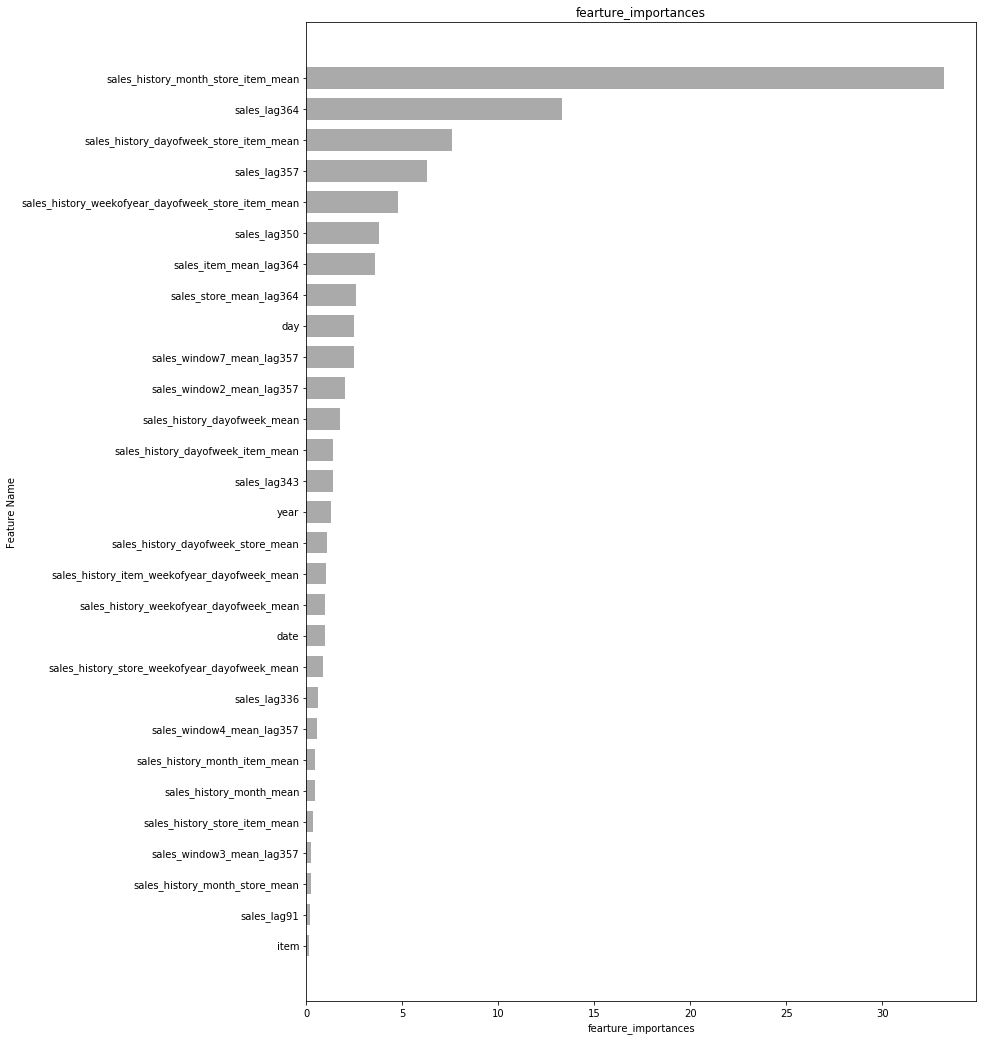

In [97]:
#feature_importances条形图,前29个重要特征
#特征重要度的计算细节详见https://tech.yandex.com/catboost/doc/dg/concepts/fstr-docpage/#fstr
ind = np.arange(len(sorted(zip(feature_importances, feature_names), reverse=True)))[:29]
fearture_importances = [score for score, name in sorted(zip(feature_importances, feature_names), reverse=True)][:29]
fearture_names = [name for score, name in sorted(zip(feature_importances, feature_names), reverse=True)][:29]

plt.rcParams['figure.figsize'] = (12, 18)
fig, ax = plt.subplots()

ax.barh(ind, fearture_importances, height=0.7, align='center', color='#AAAAAA', tick_label=fearture_names)    
ax.set_yticks(ind)
ax.set_xlabel('fearture_importances')
ax.set_ylabel('Feature Name')
ax.invert_yaxis()
ax.set_title('fearture_importances')

plt.show()

# 5.模型运用

In [98]:
validation_preds = best_model.predict(validation_pool)

In [99]:
validation.insert(validation.shape[1],'pred',validation_preds)
validation = validation[['date','store','item','sales','pred']]

In [100]:
#经存储成csv,ds又变为str了，转成datetime
validation.date=pd.to_datetime(validation.date)

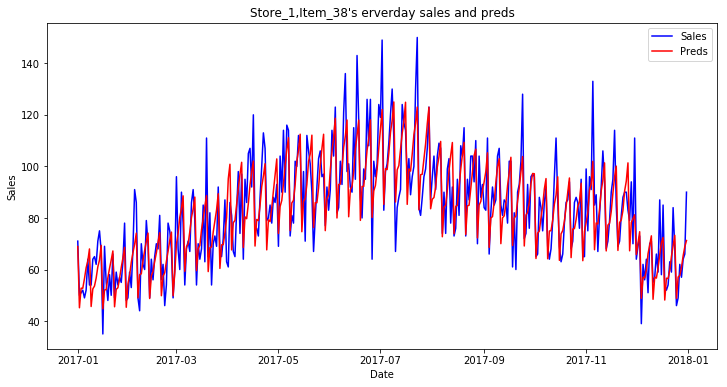

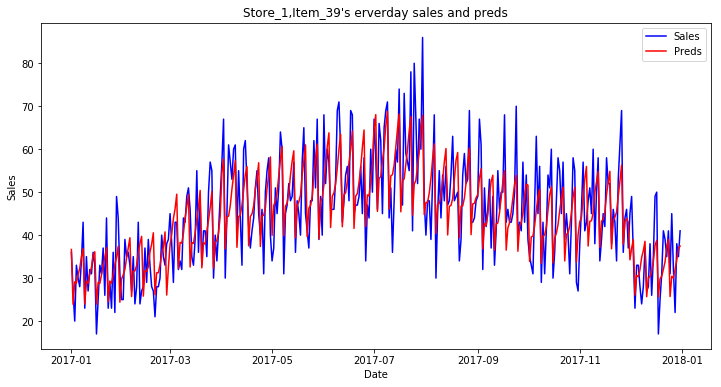

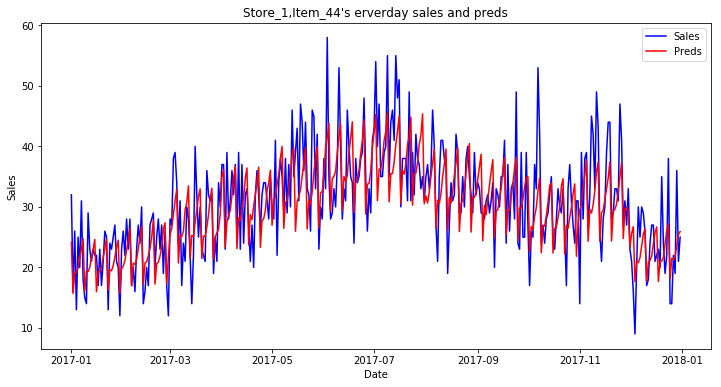

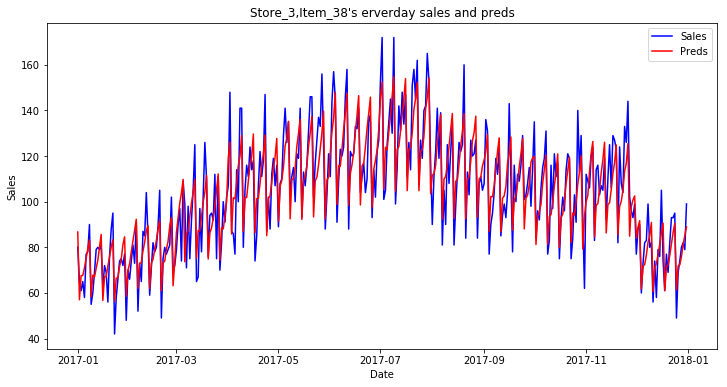

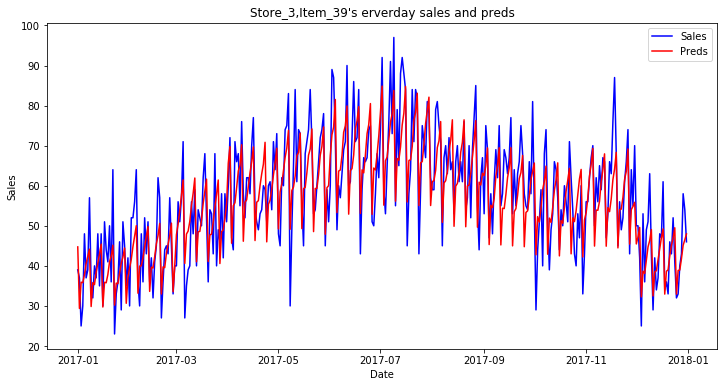

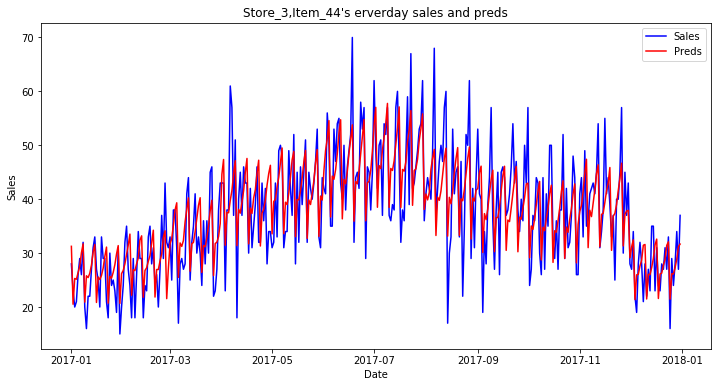

In [101]:
#随机选择2个商店、3种货物作图
a = list(np.random.choice(range(1,11), size=2, replace=False))
b = list(np.random.choice(range(1,51), size=3, replace=False))
for (s,i),group in validation.groupby(['store','item']):
    if s in a and i in b:
        plt.rcParams['figure.figsize'] = (12, 6)
        fig, ax = plt.subplots()
        
        ax.plot(group.iloc[:,0],group.iloc[:,-2],'b',label='Sales')
        ax.plot(group.iloc[:,0],group.iloc[:,-1],'r',label='Preds')
        ax.set_xlabel('Date')
        ax.set_ylabel('Sales')
        ax.set_title("Store_{0},Item_{1}'s erverday sales and preds".format(s,i))
        ax.legend()
        plt.show()

In [102]:
print(time()-start)

14634.349162101746
